# Bayesian Data Analysis - Assignment 5
___
## Generalized linear model: Bioassay with Metropolis

The target distribution can be formulated as follows:

__likelihood:__ Sampling distribution for each group $i=1...k$ in terms of the parameters $\alpha$ and $\beta$ is 

\begin{equation*}
p(y_i|\alpha,\beta,n_i,x_i) \propto [logit^{-1}(\theta_i)]^{y_i} [1-logit^{-1}(\theta_i)]^{n_i-y_i} \\
\theta_i = \alpha + \beta x_i
\end{equation*} 

where $\theta_i$ is the probability of death for animals given dose $x_i$. In addition, $n_i$ is the total amount of animals and $y_i$ is the amount of dead animals in $i^{th}$ group.

__prior:__ Joint normal prior, hence multivariate normal distribution is


\begin{equation*}
\alpha , \beta \thicksim N(\mu_{\alpha,\beta}, \Sigma_{\alpha,\beta}) \\
\mu_{\alpha,\beta} = \begin{bmatrix}0\\ 10 \end{bmatrix} 
\Sigma_{\alpha,\beta} = \begin{bmatrix}2^2 & 10\\ 10  & 10^2\end{bmatrix} 
\end{equation*}

where $\mu_{\alpha,\beta}$ is the joint mean and $\Sigma_{\alpha,\beta}$ is the joint covariance matrix.

__posterior:__ Joint posterior distribution is 
\begin{equation*}
p(\alpha, \beta | y,n,x) \propto p(\alpha,\beta) \prod_{i=1}^{k} p(y_i|\alpha,\beta,n_i,x_i)
\end{equation*}

The proposal/jumping distribution will be same as the target distribution. When computing metroplis algorithm, the new sample ($\theta^*$) is drawn from multivariate normal distribution with the mean of the previous sample ($\theta^{t-1}$). The posterior probability of the both samples is calculated with the mean of the target distribution, hence $\mu_{\alpha,\beta}$. The covariance matrix $\Sigma_{\alpha,\beta}$ stays same all the time. After that the ratio between two probabilites is calcuated and the new sample is either accepted or rejected. The metropolis algorithm has been described in more details below.

1. Draw new sample: $\theta^* \thicksim N(\theta^* | \theta^{t-1},  \Sigma_{\alpha,\beta})$ 
2. Compute posterior probability for $\theta^*$: $p(\theta^* | y,n,x) \propto N(\theta^* | \mu_{\alpha,\beta}, \Sigma_{\alpha,\beta})  \prod_{i=1}^{k} p(y_i|\theta^*,n_i,x_i) $
3. Compute posterior probability for $\theta^{t-1}$: $p(\theta^{t-1} | y,n,x) \propto N(\theta^{t-1} | \mu_{\alpha,\beta}, \Sigma_{\alpha,\beta})  \prod_{i=1}^{k} p(y_i|\theta^{t-1},n_i,x_i) $
4. Compute the ratio between two probabilities: $r=exp(p(\theta^* | y,n,x)-p(\theta^{t-1} | y,n,x))$
5. Draw a random sample between 0 and 1 from the uniform distribution ($p$)
6. Accept the new sample only if $r > p $. OTherwise keep the previous sample.
7. Repeat steps 1 to 6 for $k$ times

The algorithm was computed for 4 chains by taking $5000$ draws per chain and starting from the following dispersed starting points:

\begin{equation*}
\mu_{\alpha_0,\beta_0} =  \begin{bmatrix} -4 \\ 30 \end{bmatrix}, \mu_{\alpha_0,\beta_0} =  \begin{bmatrix} -4 \\ 10 \end{bmatrix},
\mu_{\alpha_0,\beta_0} =  \begin{bmatrix} 4 \\ -5 \end{bmatrix}, \mu_{\alpha_0,\beta_0} =  \begin{bmatrix} 5 \\ 40 \end{bmatrix}  
\end{equation*}

The simulation of the algorithm is simulated below (red points are the starting points). The rejection ratio of the 4 chains (~76%) was inside limits (60%-90% introduced in the lecture). 

The rejected samples on average:  0.7613


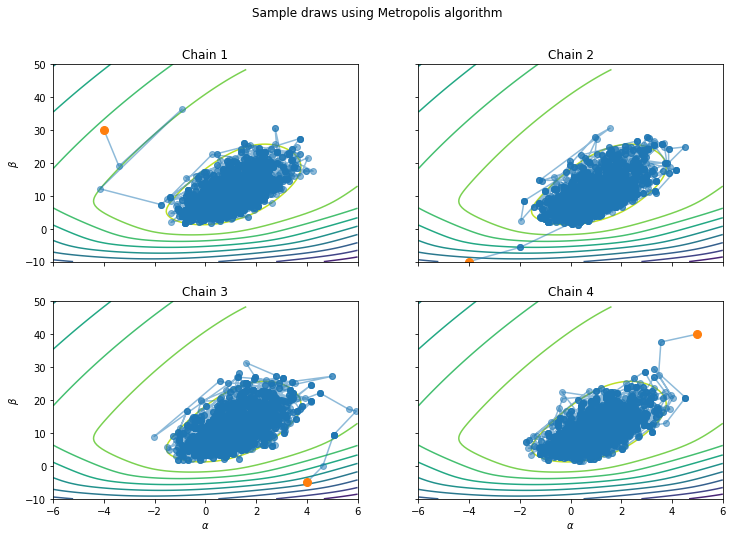

In [2]:
plot_metropolis_simulation()

___
After simulation half of the samples (2500) were removed from the beginning (=warm-up length). The resulting samples are plotted below.

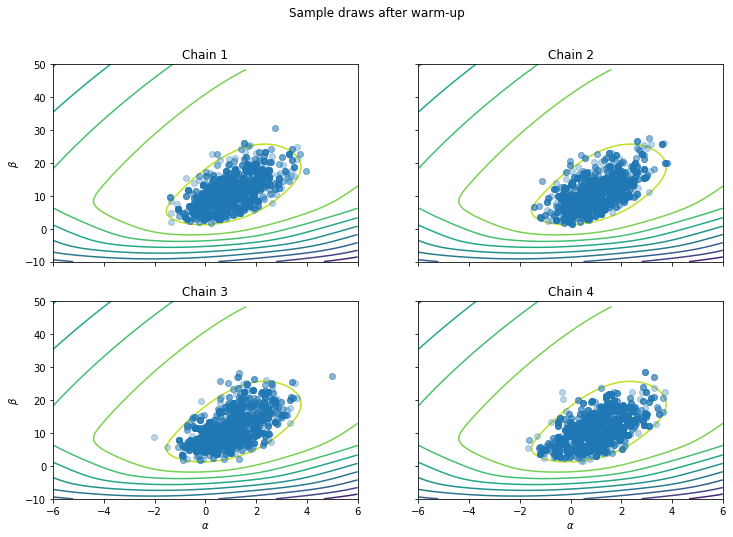

In [3]:
plot_sample_draws_without_warmup()

___

The convergence of the chains is shown visually in the first two plots and the computed $\hat R$ values are displayed above the plots. The $\hat R$ values inform how close the variation between and within simulated chains are. If these both variations are close to each other, the $\hat R$  value will be close to 1. This means that all the chains are approximating the same target distribution. The approximated target distribution can be used as any other distribution: computing quantities of the interest and montioring the inference of the parameters $\alpha$ and $\beta$.

R hat value for α and β:  [1.00162321 1.00266984]


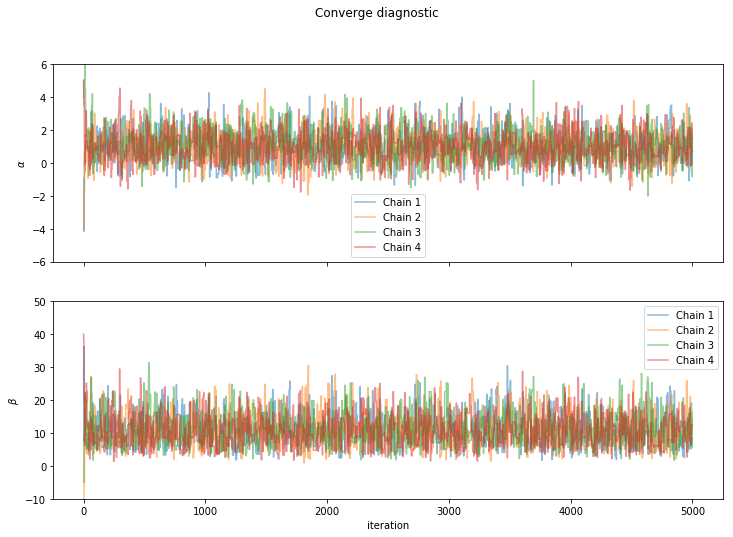

In [4]:
compute_rhat()
show_converge_plot()

___


## Attachment 1: Source code

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from math import sqrt
from scipy import stats, linalg
from psrf import psrf
from bioassaylp import bioassaylp

np.random.seed(seed=123)

x = np.asarray([-0.86, -0.30, -0.05, 0.73]) 
n = np.asarray([5, 5, 5, 5]) 
y = np.asarray([0, 1, 3, 5])

prior_mean = (0,10)
prior_cov = np.asarray(((2**2, 10), (10, 10**2)))

def get_target_posterior():
    # Construct a grid array of shape (ngrid, ngrid, 2) from X and Y
    def compute_broadcasted(X,Y,ngrid):
        X_broadcasted = np.lib.stride_tricks.as_strided(
            X, shape=(ngrid, ngrid), strides=(0, X.strides[0]))
        Y_broadcasted = np.lib.stride_tricks.as_strided(
            Y, shape=(ngrid, ngrid), strides=(Y.strides[0], 0))
        return {'X':X_broadcasted, 'Y':Y_broadcasted}
    ngrid=100
    broadcasted = compute_broadcasted(np.linspace(-6, 6, ngrid),np.linspace(-10, 50, ngrid),ngrid)
    A_broadcasted=broadcasted['X']
    B_broadcasted=broadcasted['Y']
    
    #Compute target posterior desity
    prior = stats.multivariate_normal.logpdf(x=np.dstack((A_broadcasted, B_broadcasted)), mean=prior_mean, cov=prior_cov)
    likelihood = bioassaylp(A_broadcasted,B_broadcasted,x,y,n)
    posterior = likelihood+prior
    return {'density': posterior, 'A':A_broadcasted, 'B':B_broadcasted}

def log_likelihood(a, b,x,y,n):     
    # these help using chain rule in derivation
    t = a + b * x
    et = np.exp(t)
    z = et / (1. + et)
    z_negative = 1-z
    z_negative = np.array([i if i > 0 else 1e-12 for i in z_negative])
    # negative log posterior (error function to be minimized)
    llh = np.sum(y * np.log(z) + (n - y) * np.log(z_negative), axis=-1)
    return llh

def log_posterior(theta):
    prior = stats.multivariate_normal.logpdf(x=theta, mean=prior_mean, cov=prior_cov)
    likelihood = log_likelihood(theta[0],theta[1],x,y,n)
    return likelihood+prior

rejected_ratio =[]
def metropolis_algorithm(theta0, tmax):
    algo_samples = [theta0]
    accepted=0
    rejected=0
    for t in range(1,tmax):
        # Take next sample from the distribution with the mean of the previous theta, hecne theta at t-1
        theta_prev=algo_samples[t-1]
        theta_next=stats.multivariate_normal.rvs(mean=theta_prev, cov=prior_cov, size=1)   
        
        # Compute posteriors and their ratio r
        p_theta_prev = log_posterior(theta_prev)
        p_theta_next = log_posterior(theta_next)
        r=min(np.exp(p_theta_next-p_theta_prev),1)
        
        #Take probability uniformly
        p=np.random.uniform(0,1,1)

        if (r > p): #Accept new theta
            algo_samples.append(theta_next)
        else: #Keep old theta
            algo_samples.append(theta_prev)
            rejected+=1
            
    #Rejection rule: 60-90%
    rejected_ratio.append(rejected/tmax)
    return np.array(algo_samples)

#Compute metropolis algorithm for 4 chains
nsamples = 5000
theta0 = [[-4,30],[-4,-10],[4,-5],[5,40]]
chains = [ metropolis_algorithm(theta0[i],nsamples) for i in range(0,4) ]
rejected_ratio_avg = np.mean(rejected_ratio)

#Compute target posterior
print("Note! The red error below is only used to compute the background of the plots.")
target_posterior = get_target_posterior()

######################### Sample draws using Metropolis algorithm #########################
def plot_metropolis_simulation():
    print("The rejected samples on average: ", rejected_ratio_avg)
    subplotshape = (2, 2)
    fig, axes = plt.subplots(2, 2, sharex=True, sharey=True,figsize=(12,8), subplot_kw=dict(aspect='auto'))
    fig.suptitle('Sample draws using Metropolis algorithm')
    # set limits
    axes[0,0].set_xlim([-6, 6])
    axes[0,0].set_ylim([-10, 50])

    # set labels
    for i in range(subplotshape[0]):
        axes[i,0].set_ylabel(r'$\beta$')
    for j in range(subplotshape[1]):
        axes[-1,j].set_xlabel(r'$\alpha$')
    chain_axes = [axes[0,0],axes[0,1],axes[1,0],axes[1,1]]
    for i in range(0, len(chains)):
        chain_axes[i].plot(chains[i][:,0],chains[i][:,1], '-o', alpha=0.5)
        chain_axes[i].plot(theta0[i][0],theta0[i][1], 'o', markersize=8)
        chain_axes[i].set_title('Chain '+str(i+1))
        chain_axes[i].contour(target_posterior['A'], target_posterior['B'], target_posterior['density'], 10)
    
######################### Sample draws without warm-up #########################
#Warm up: remove half of the samples from the beginning
startIndex = int(nsamples/2)

def plot_sample_draws_without_warmup():
    subplotshape = (2, 2)
    fig, axes = plt.subplots(2, 2, sharex=True, sharey=True,figsize=(12,8), subplot_kw=dict(aspect='auto'))
    fig.suptitle('Sample draws after warm-up')
    # set limits
    axes[0,0].set_xlim([-6, 6])
    axes[0,0].set_ylim([-10, 50])

    # set labels
    for i in range(subplotshape[0]):
        axes[i,0].set_ylabel(r'$\beta$')
    for j in range(subplotshape[1]):
        axes[-1,j].set_xlabel(r'$\alpha$')
    chain_axes = [axes[0,0],axes[0,1],axes[1,0],axes[1,1]]
    for i in range(0, len(chains)):
        chain_axes[i].plot(chains[i][startIndex:,0],chains[i][startIndex:,1], 'o', alpha=0.3)
        chain_axes[i].set_title('Chain '+str(i+1))
        chain_axes[i].contour(target_posterior['A'], target_posterior['B'], target_posterior['density'], 10)
    plt.show()
######################### Converge diagnostic #########################
def show_converge_plot():
    fig, axes = plt.subplots(2, 1, sharex=True,figsize=(12,8), subplot_kw=dict(aspect='auto'))
    fig.suptitle('Converge diagnostic')

    # set limits
    axes[0].set_ylim([-6, 6])
    axes[1].set_ylim([-10, 50])
    # set labels
    axes[0].set_ylabel(r'$\alpha$')
    axes[1].set_ylabel(r'$\beta$')
    axes[1].set_xlabel('iteration')

    for i in range(0, len(chains)):
        axes[0].plot(range(0,nsamples),chains[i][:,0], label="Chain "+str(i+1), alpha=0.5)
        axes[1].plot(range(0,nsamples),chains[i][:,1], label="Chain "+str(i+1), alpha=0.5)

    # show Legend
    axes[0].legend()
    axes[1].legend()
    plt.show()

######################### R hat #########################
#R hat compares the means and the variances of the chains
def compute_rhat():
    chains_without_warmup = np.array([c[startIndex:] for c in chains ])
    r_hat = psrf(chains_without_warmup, return_extra=True)
    print(r'R hat value for α and β: ', r_hat[0])
    #print(r'N effective for α and β: ', r_hat[1])
    #print(r'Vh for α and β: ', r_hat[2])
    #print(r'W for α and β: ', r_hat[3])
    #print(r'B for α and β: ', r_hat[4])
    #print(r'Tau for α and β: ', r_hat[5])


Note! The red error below is only used to compute the background of the plots.


/home/dinht/repos/conda_jupyter/bioassaylp.py:32: RuntimeWarning: divide by zero encountered in log
  lp = np.sum(y*np.log(z)+ (n-y)*np.log(1.0-z), axis=-1)
/home/dinht/repos/conda_jupyter/bioassaylp.py:32: RuntimeWarning: invalid value encountered in multiply
  lp = np.sum(y*np.log(z)+ (n-y)*np.log(1.0-z), axis=-1)
